# FIXME

1. [x] Clean up the file
  - [x] Clean up the imports
  - [x] Clean up the helper functions - ultimately these should use the libraries
  - [x] Clean up the plots
2. [ ] Figure out exactly which variables need to be swept over
3. [ ] Write the sweeping logic and sanity check it
4. [ ] Write the naive interpolation logic
5. [ ] Measure the error for random points on the interpolation space
6. [ ] Attempt to develop a better approximation using rational functions

# Methods

We desire an approximation for the maximum amount of bonds that a trader can short given the ratio of their cash balance to the AMMs cash reserve. To do this, we can calculate the maximum loss for short positions opened with a range of APRs, time remaining, and ratios of bonds to the total bond reserves. For a fixed APR and time remaining, we'll have an array of the maximum loss and the bond ratios shorted. We can find an approximation that tightly fits these points, which is a function of a max loss in base that outputs the ratio of bonds required to hit the max loss.

## TODO - Add detail about the interpolation.

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg.special_matrices import math
from scipy.optimize import curve_fit

In [36]:
def calc_k_const(share_reserves, bond_reserves, share_price, init_share_price, time_remaining):
    """Returns the 'k' constant variable for trade mathematics"""
    scale = share_price / init_share_price
    return scale * (init_share_price * share_reserves) ** (1 - time_remaining) + (bond_reserves) ** (
        1 - time_remaining
    )

def calc_bond_reserves(share_reserves, apr, share_price, init_share_price, time_remaining):
    """Calculates the bond reserves from the share reserves and a target apr"""
    return (init_share_price * share_reserves) * (1 + apr * time_remaining) ** (1 / time_remaining)

# FIXME: This doesn't incorporate fees
def calc_max_loss(share_reserves, bond_reserves, d_bonds, share_price, init_share_price, time_remaining):
    k = calc_k_const(share_reserves, bond_reserves, share_price, init_share_price, time_remaining)
    d_shares = share_reserves - (1 / init_share_price) * ((init_share_price / share_price) * (k - (bond_reserves + d_bonds) ** (1 - time_remaining))) ** (1 / (1 - time_remaining))
    return d_bonds - d_shares

def calc_max_loss_from_apr(share_reserves, bond_percentage, apr, share_price, init_share_price, time_remaining):
    bond_reserves = calc_bond_reserves(share_reserves, apr, share_price, init_share_price, time_remaining)
    d_bonds = bond_reserves * bond_percentage
    return calc_max_loss(share_reserves, bond_reserves, d_bonds, share_price, init_share_price, time_remaining)    

In [37]:
# FIXME: We may not need to sweep over c, mu, and z.
# Simulation Variables
c = 1           # share price
mu = 1          # init share price
z = 10**6       # share reserves -- this is arbitrary for this analysis
apr = 0.02       # apr
t = 0.5         # time remaining
y_percent = 0.1 # percent of bond reserves to be shorted

# Other Variables
verbose = False

In [38]:
# FIXME: This will ultimately be where the sweep code lives.
# FIXME: We should be able to start at zero. We may need to add a constant term
#        to the log.
 
# Capture an array of max losses (the x component) and the bond ratios (the y component) 
# that require the max losses.
x = []
y = range(1, 101) # FIXME: Add back in 0
for y_ in y:
    max_loss = calc_max_loss_from_apr(z, 0.01 * y_, apr, c, mu, t)
    max_loss_percent = (max_loss / z) * 100
    x.append(max_loss_percent)
    if verbose:
      print(
          f"bond percent = {y_}"
          f"\n\tmax loss = {max_loss}"
          f"\n\tmax loss percent = {max_loss_percent}"
      )
x = np.array(x)
y = np.array(y)

Text(0, 0.5, 'Bond Percent')

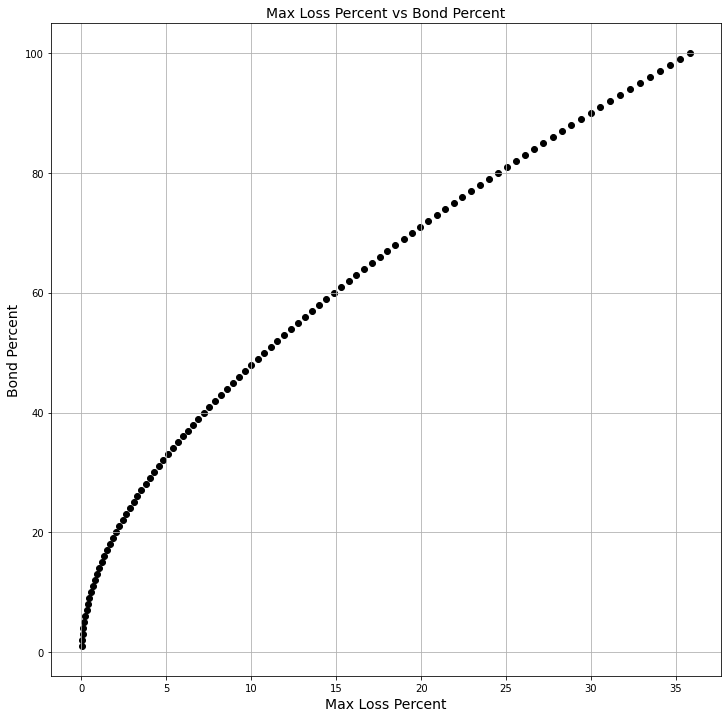

In [39]:
# Plot the raw data output by the sweep
plt.subplots(figsize=(12,12))
plt.scatter(x,y,color='black')
plt.grid(True)
plt.title('Max Loss Percent vs Bond Percent', fontsize=14)
plt.xlabel('Max Loss Percent', fontsize=14)
plt.ylabel('Bond Percent', fontsize=14)

In [40]:
# Approximate the data with a Chebyshev polynomial
c = np.polynomial.Chebyshev.fit(x, y, deg=20)

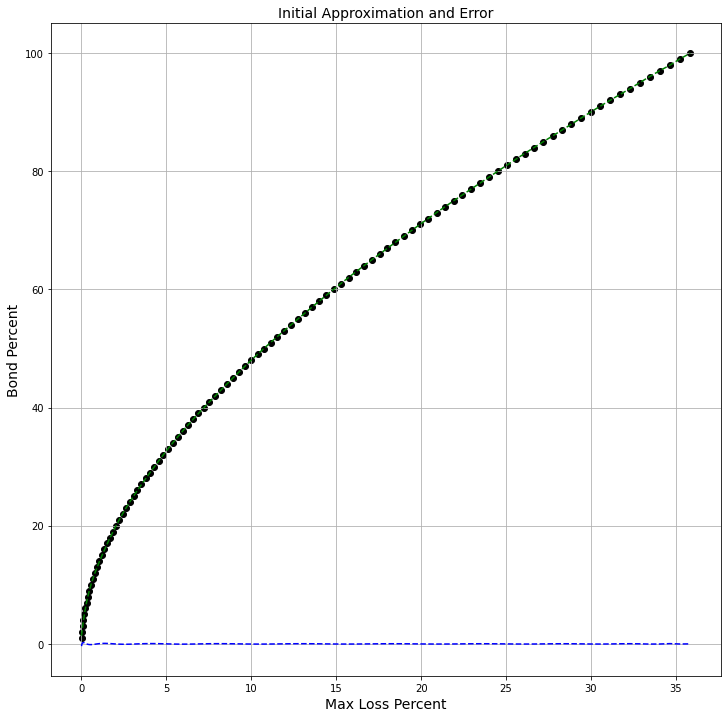

In [41]:
# Plot the Chebyshev approximation against the raw data
plt.subplots(figsize=(12,12))
plt.scatter(x,y,color='black')
plt.grid(True)
plt.title('Initial Approximation and Error', fontsize=14)
plt.xlabel('Max Loss Percent', fontsize=14)
plt.ylabel('Bond Percent', fontsize=14)

y_approx = c(x)
plt.plot(x, y_approx, '--', color="green")
plt.plot(x, y - y_approx, '--', color="blue")

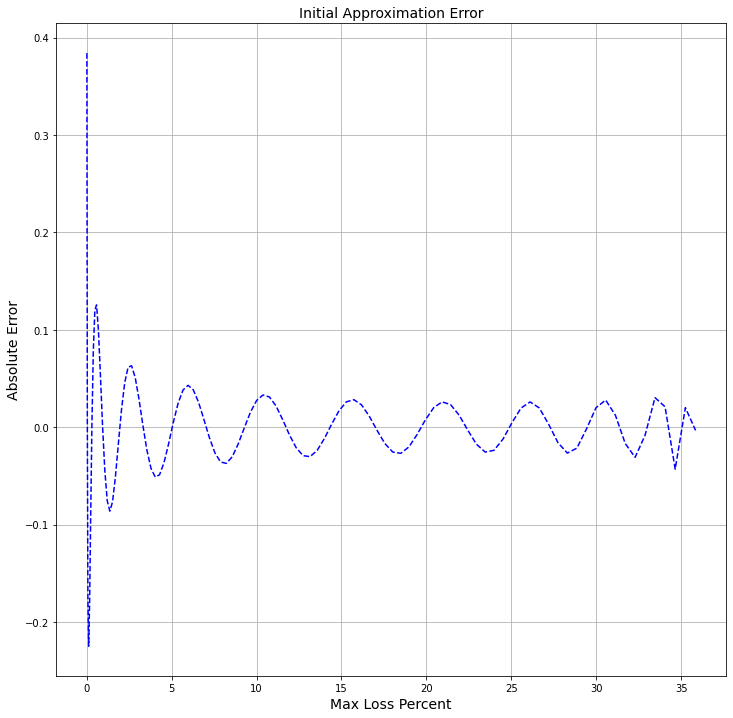

In [42]:
# Plot the absolute error from the initial Chebyshev polynomial
plt.subplots(figsize=(12,12))
plt.grid(True)
plt.title('Initial Approximation Error', fontsize=14)
plt.xlabel('Max Loss Percent', fontsize=14)
plt.ylabel('Absolute Error', fontsize=14)

plt.plot(x, y_approx - y, '--', color="blue")